In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars as pl
from pathlib import Path


from scipy import signal
import ssm

from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy.signal import savgol_filter
import pandas as pd
import joblib

from transphorm.preprocessors.loaders import AADataLoader
from transphorm.analyzers import ARHMMAnalyzer
from dotenv import load_dotenv

load_dotenv()


True

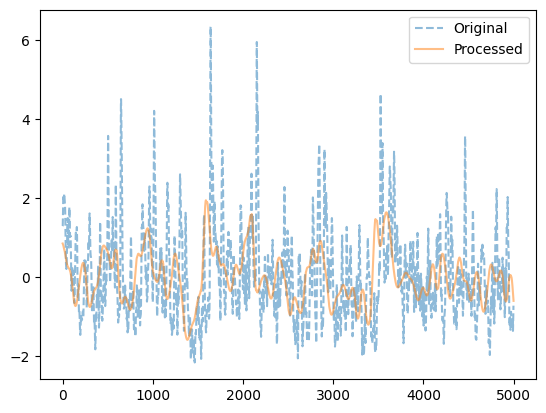

In [6]:
# model_path = Path("/projects/p31961/transphorm/models/arhmm/mutual_title_6196.joblib")
data_path = Path("/Users/mds8301/Desktop/temp/da_full_timeseries_partitioned_learning.pt")
# model = joblib.load(model_path)
loader = AADataLoader(data_path, 
                      weiner_filter=True,
                      weiner_window_size=1071,
                      smoothing=True,
                      smoothing_window_size=1071,
                      down_sample=True)
loader.load_data()
loader.prepare_data()
original = loader.data[0][::25][1:5000]
# convolve with a 500 point moving average
plt.plot(original, label='Original', alpha=0.5, linestyle='--')

plt.plot(loader.x[0][:5000], label='Processed', alpha=0.5, linestyle='-')
plt.legend()
plt.show()